In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./Teams.csv
./TeamConferences.csv
./MasseyOrdinals_thru_2019_day_128.csv
./NCAATourneySeeds.csv
./SecondaryTourneyTeams.csv
./NCAATourneySeedRoundSlots.csv
./RegularSeasonDetailedResults.csv
./RegularSeasonCompactResults.csv
./TeamCoaches.csv
./Cities.csv
./SecondaryTourneyCompactResults.csv
./GameCities.csv
./logreg_on_seed_2019.csv
./2019SeedDifference.ipynb
./TeamSpellings.csv
./Seasons.csv
./ConferenceTourneyGames.csv
./Conferences.csv
./NCAATourneySlots.csv
./NCAATourneyCompactResults.csv
./NCAATourneyDetailedResults.csv
./.ipynb_checkpoints/2019SeedDifference-checkpoint.ipynb


In [2]:
# Importing the libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss 
from sklearn.metrics import classification_report

import seaborn as sns
from IPython.display import display

In [3]:
data_dir = './'
df_seeds = pd.read_csv(data_dir + 'NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')

In [4]:
df_tour.drop(labels=['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)


### Get the seeds as Integers


In [5]:
def seed_to_int(seed):
    """Get just the digits from the seeding. Return as int"""
    s_int = int(seed[1:3])
    return s_int
df_seeds['n_seed'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

In [6]:
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


### Merge seed for each team
We want the seeds in the same DataFrame as the game results

In [7]:
df_winseeds = df_seeds.rename(columns={'TeamID':'WTeamID', 'n_seed':'win_seed'})
df_lossseeds = df_seeds.rename(columns={'TeamID':'LTeamID', 'n_seed':'loss_seed'})

In [9]:
df_dummy = pd.merge(left=df_tour, right=df_winseeds, how='left', on=['Season', 'WTeamID'])
df_concat = pd.merge(left=df_dummy, right=df_lossseeds, on=['Season', 'LTeamID'])
df_concat['seed_diff'] = df_concat.win_seed - df_concat.loss_seed

### Make a new DF with just the wins and losses


In [10]:
df_wins = pd.DataFrame()
df_wins['seed_diff'] = df_concat['seed_diff']
df_wins['result'] = 1

df_losses = pd.DataFrame()
df_losses['seed_diff'] = -df_concat['seed_diff']
df_losses['result'] = 0

df_for_predictions = pd.concat((df_wins, df_losses))


In [11]:
from sklearn.utils import shuffle
X_train = df_for_predictions.seed_diff.values.reshape(-1,1)
y_train = df_for_predictions.result.values
X_train, y_train = shuffle(X_train, y_train)


### Train the estimator
We use logistic regression, so we have to set a C value. We can just try a bunch of different values and then choose the best one.

In [12]:
from sklearn.model_selection import GridSearchCV
logreg = LogisticRegression()
params = {'C': np.logspace(start=-5, stop=3, num=9)}
clf = GridSearchCV(logreg, params, scoring='neg_log_loss', refit=True)
clf.fit(X_train, y_train)
print('Best log_loss: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C']))

Best log_loss: -0.5548, with best C: 0.01


### Examine the classifier predictions

In [13]:
X = np.arange(-16, 16).reshape(-1, 1)
preds = clf.predict_proba(X)[:,1]

Text(0, 0.5, 'P(Team1 will win)')

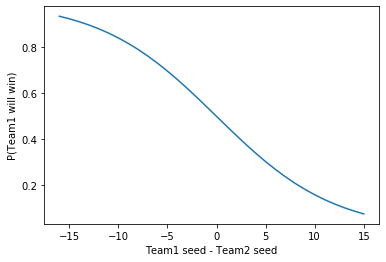

In [14]:
plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

This looks like we would expect. We are predicting the probability of team1 winning. If that team has a lower seed than team2, there is a high probability of team1 winning.

### Get the test data


In [15]:
df_sample_sub = pd.read_csv('./../SampleSubmissionStage2.csv')
n_test_games = len(df_sample_sub)

In [16]:
def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

We loop over each row in the sample_submission.csv file. For each row, we extract the year and the teams playing. We then look up the seeds for each of those teams in that season. Finally we add the seed difference to an array.

In [17]:
df_sample_sub.head()

,ID,Pred
0,2019_1101_1113,0.5
1,2019_1101_1120,0.5
2,2019_1101_1124,0.5
3,2019_1101_1125,0.5
4,2019_1101_1133,0.5


In [18]:
X_test = np.zeros(shape=(n_test_games, 1))
for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    # There absolutely must be a better way of doing this!
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].n_seed.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].n_seed.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii, 0] = diff_seed


In [19]:
preds = clf.predict_proba(X_test)[:,1]


In [20]:
clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2019_1101_1113,0.339754
1,2019_1101_1120,0.159631
2,2019_1101_1124,0.269613
3,2019_1101_1125,0.339754
4,2019_1101_1133,0.500000


In [21]:
df_sample_sub.describe()

,Pred
count,2278.000000
mean,0.492246
std,0.228541
min,0.076459
25%,0.303542
50%,0.500000
75%,0.696458
max,0.923541


In [22]:
df_sample_sub.to_csv('logreg_on_seed_2019.csv', index=False)


## Log loss 0.51443